In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import HelperFunctions as hf

# Prepare Data

In [19]:
#load data
sales_df= hf.load_sales_train_validation_data()
calendar_df= hf.load_calendar_data()
prices_df= hf.load_sell_price_data()

In [20]:
#clean data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1300, items=1000, dropNAPrices=True)

In [21]:
df.shape

(901753, 42)

In [22]:
#add rolling mean
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
#df = hf.rollingMeanDemandFeature(df, windowSize=365, shift=1) 

df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
#df = hf.rollingStdDemandFeature(df, windowSize=365, shift=1)


df = hf.rollingMeanWeekday(df, weeks = 4, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 8, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 52, shift = 1) #mean of previous 3 weeks (for that particular weekday)

#add lag
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before
#df = hf.lagFeature(df, var='sold', lag=365) #Amount sold 1 year before

df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [23]:
#product_ids = df.id.copy()
#df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [24]:
df.head()

,id,d,sold,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,...,rolling_mean_7_1,rolling_mean_28_1,rolling_std_7_1,rolling_std_28_1,rolling_mean_4_1,rolling_mean_8_1,rolling_mean_52_1,sold_lag_1,sold_lag_7,sold_lag_28
196002,HOUSEHOLD_2_134_CA_4_validation,197,0,1,8,2011,0,1,0,5.94,...,0.000000,0.071429,0.000000,0.262265,0.0,0.125,0.057692,0,0,0
196008,FOODS_3_271_CA_1_validation,197,0,1,8,2011,0,1,0,4.98,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.403846,0,0,0
198012,HOUSEHOLD_2_421_WI_3_validation,199,0,3,8,2011,0,1,1,4.67,...,1.714286,1.321429,1.253566,0.904866,1.5,1.375,1.884615,2,2,2
198013,HOUSEHOLD_2_301_WI_2_validation,199,0,3,8,2011,0,1,1,2.27,...,0.857143,1.107143,1.069045,1.523624,1.0,1.125,0.942308,1,0,4
198014,HOUSEHOLD_1_432_CA_2_validation,199,0,3,8,2011,0,1,1,3.97,...,1.000000,0.428571,1.914854,1.069045,0.0,0.500,0.250000,0,0,0


In [25]:
df.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_std_7_1', 'rolling_std_28_1', 'rolling_mean_4_1',
       'rolling_mean_8_1', 'rolling_mean_52_1', 'sold_lag_1', 'sold_lag_7',
       'sold_lag_28'],
      dtype='object')

In [26]:
#Standardise features
from sklearn.preprocessing import MinMaxScaler

cols_to_norm = ['d','wday','month','year','sell_price', "rolling_std_28_1",\
                "rolling_mean_4_1", "rolling_mean_8_1", "rolling_mean_52_1", \
                "rolling_mean_28_1", "rolling_std_7_1", "rolling_mean_7_1"]

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [27]:
df_item = df.loc[df["id"] == "FOODS_2_360_TX_3_validation"]
df_test = df.loc[df["d"] > 1200/1300]
df = df.loc[df["d"] <= 1200/1300]

In [28]:
#Train set
#df.drop(['id'], axis=1, inplace=True) #Drop the id column
X_train=df.drop(["id",'sold'],axis=1).values
y_train=df['sold'].values

In [29]:
#Test set
#df_test.drop(['id'], axis=1, inplace=True) #Drop the id column
X_test=df_test.drop(["id",'sold'],axis=1).values
y_test=df_test['sold'].values

# Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression

lm=LinearRegression()
lm.fit(X_train,y_train)
preds_test=lm.predict(X_test)
preds_train=lm.predict(X_train)

In [31]:
#error
from sklearn.metrics import mean_squared_error

print(f"MSE on train set: {mean_squared_error(preds_train,y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test,y_test)}")

MSE on train set: 6.699316799719208
MSE on test set: 6.300634384809979


In [32]:
from sklearn.model_selection import cross_val_score

model=LinearRegression()

cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-6.63724921 -6.94284883 -6.31310675 -7.16489229 -6.67439131]
MSE CV: 6.746497678425281


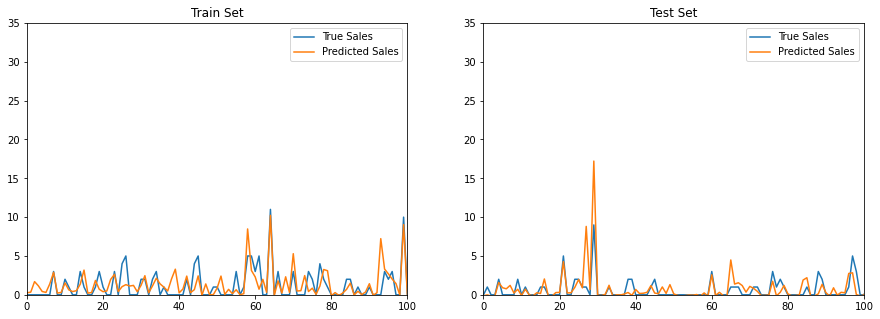

In [33]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

# LightGBM (LGBM)

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

pip install lightgbm

In [34]:
import lightgbm as lgb

model=lgb.LGBMRegressor(learning_rate=0.05,
                        boosting_type="gbdt",  
                        objective="regression",
                        metric="mse",
                        num_leaves=50,
                        max_depth=10,
                        n_estimators=100)

X_train.astype(float)
X_test.astype(float)
y_train.astype(float)
y_test.astype(float)

model.fit(X_train, y_train)

preds_train=model.predict(X_train)
preds_test=model.predict(X_test)


print(f"MSE on train set: {mean_squared_error(y_train, preds_train)}")
#print(f"RMSE on train set: {mean_squared_error(y_train, preds_train)**0.5}")
print()
print(f"MSE on test set:  {mean_squared_error(y_test, preds_test)}")
#print(f"RMSE on test set:  {mean_squared_error(y_test, preds_test)**0.5}")

MSE on train set: 4.931413422570927

MSE on test set:  5.889247816407852


In [35]:
#cross validation 
from sklearn.model_selection import cross_val_score

model=lgb.LGBMRegressor(learning_rate=0.05,
                        boosting_type="gbdt",  
                        objective="regression",
                        metric="mse",
                        num_leaves=50,
                        max_depth=10,
                        n_estimators=100)

cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-6.35911196 -6.51231656 -5.90194605 -6.77127303 -5.97483881]
MSE CV: 6.30389728049406


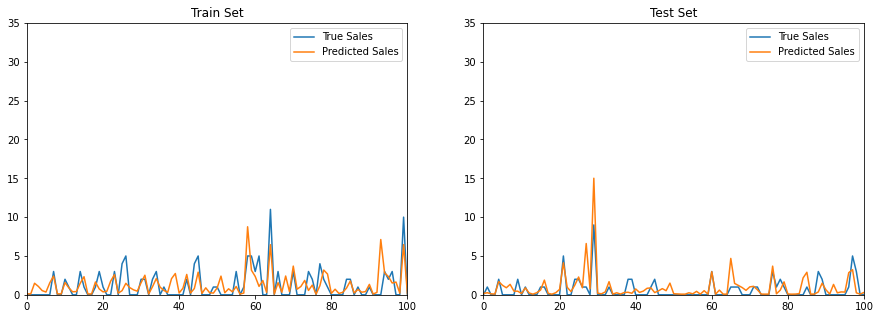

In [36]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

#  XGBoost

In [37]:
import xgboost as xgb

model = xgb.XGBRegressor(learning_rate = 0.05, 
                           max_depth = 10, 
                           alpha = 10, 
                           n_estimators = 110)

model.fit(X_train,y_train)

preds_train= model.predict(X_train)
preds_test = model.predict(X_test)


print(f"MSE on train set: {mean_squared_error(y_train, preds_train)}")
#print(f"RMSE on train set: {mean_squared_error(y_train, preds_train)**0.5}")
print()
print(f"MSE on test set:  {mean_squared_error(y_test, preds_test)}")
#print(f"RMSE on test set:  {mean_squared_error(y_test, preds_test)**0.5}")

MSE on train set: 3.078045418718176

MSE on test set:  6.043468741240799


In [39]:
#cross validation 
from sklearn.model_selection import cross_val_score

model = xgb.XGBRegressor(learning_rate = 0.05, 
                           max_depth = 10, 
                           alpha = 10, 
                           n_estimators = 110)

model.fit(X_train,y_train)


cv_score=cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-6.58057433 -6.79341781 -6.06316397 -7.18951927 -7.47756557]
MSE CV: 6.8208481888326435


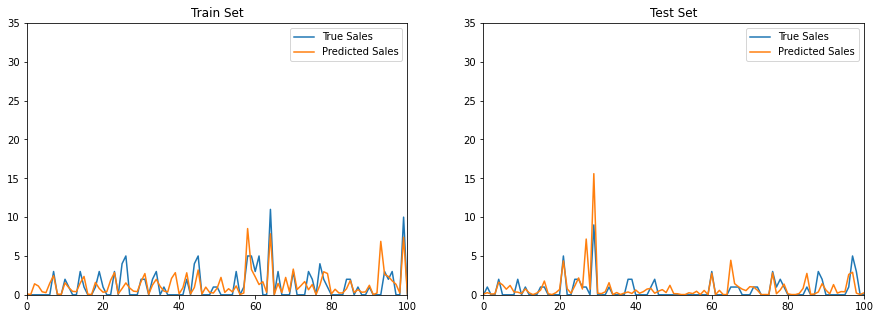

In [40]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

# Hist Gradient Boosting Regressor

Its in sklearn and it says it is inspired from LightGBM so lets try it

In [41]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

model=HistGradientBoostingRegressor()
model.fit(X_train, y_train)
preds_train=model.predict(X_train)
preds_test=model.predict(X_test)

In [42]:
print(f"MSE on train set: {mean_squared_error(preds_train,y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test,y_test)}")

MSE on train set: 5.581871643455265
MSE on test set: 6.152608410468594


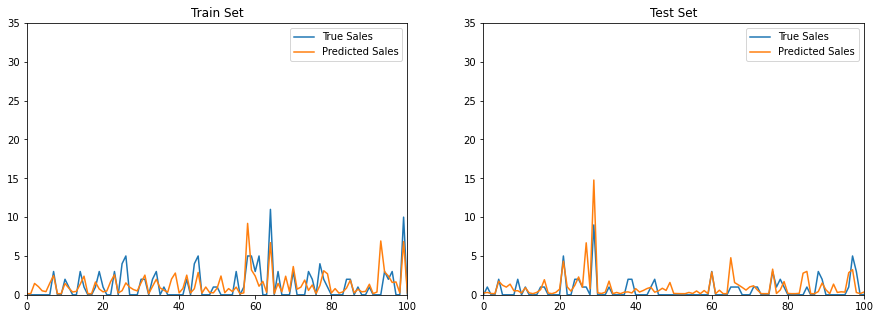

In [43]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()